<a href="https://colab.research.google.com/github/michalshavitNYU/michalshavitnyu.github.io/blob/master/Nov_train_beta_strat_from_previous_RotationalCapillaryStokeWave_nhlb_dbhump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kfac_jax==0.0.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.0/161.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.4 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


In [3]:
import sys
import jax
import jax.numpy as jnp

import numpy as np
import optax

import abc

from jax import random, vjp, vmap
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import savemat
from scipy.interpolate import interp1d
from pathlib import Path
import pickle

In [4]:
import kfac_jax

In [5]:
from kfac_jax import curvature_estimator
from kfac_jax import curvature_blocks
from kfac_jax import layers_and_loss_tags
from kfac_jax import loss_functions as kfac_loss_functions
from kfac_jax import optimizer as kfac_optim



In [6]:
# change JAX to double precision
jax.config.update('jax_enable_x64', True)

# define the root path
rootdir = Path('/content/drive').joinpath('MyDrive')

# Customized function for collocation point arrangement

In [7]:
import scipy
import jax.scipy as jsp

def gaussian1D_smooth(f, sig, wid):
    '''
    :param f: equally spaced 1D position matrix  (N, 1)
    :param sig: stan. devi of gaussian filter (1, ) or scalor
    :param wid: wid of the filter matrix (1, ) or scalor integer
    '''
    wid = jnp.int32(wid)
    xg = jnp.linspace(-sig, sig, wid)
    window = jsp.stats.norm.pdf(xg)
    win_n = window / jnp.sum(window)
    f_smooth = scipy.signal.convolve(f[:, 0], win_n, mode='same')[:, None] #f[:, 0] selects the first (and only) column of f, turning it into a 1D array of shape (N,).
    return f_smooth


# sample the data based on a given probability distribution
def colloc1D_set(key, x, f, Ns):
    '''
    :param x: 1-D position array (N, 1)
    :param f: 1-D distribution array (N, 1)
    :param Ns: number of points to sample
    '''
    # remove last element in each direction
    xc = x[0:-1, :]
    fc = f[0:-1, :]
    dx = xc[1] - xc[0]
    seq = jnp.arange(fc.shape[0] + 1)
    # generate key for random variables
    keys = jax.random.split(key, num=2)

    # obtain the cumulative sum of the z value
    b = jnp.hstack([0., jnp.cumsum(fc)])
    # obtain the random variable
    c = jax.random.uniform(keys[0], [Ns]) * b[-1]
    # generate the index position of each collocation point following the distribution
    # (using the interpolate the index of grid where each random variable stands)
    posi_intp = jnp.interp(c, b, seq)
    # round the result to guarantee that the index position is integer
    posi = jnp.int32(jnp.floor(posi_intp))
    # obtain the real position of each collocation point
    px = xc[posi, :]
    # generate a random fraction for each collocation point
    posi_add = jax.random.uniform(keys[1], [c.shape[0], 1])
    # add the random fraction to the position of each collocation points
    x_col = px + posi_add * dx

    return x_col


# Weight initialization and network architecture

In [8]:
# initialize the neural network weights and biases
def init_MLP(parent_key, layer_widths):
    params = []
    keys = random.split(parent_key, num=len(layer_widths) - 1)
    # create the weights and biases for the network
    for in_dim, out_dim, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = random.split(key)
        xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
        params.append(
            [random.truncated_normal(weight_key, -2, 2, shape=(in_dim, out_dim)) * xavier_stddev,
             random.truncated_normal(bias_key, -2, 2, shape=(out_dim,)) * xavier_stddev]
        )
    return params


#Load weights from previous run #Added by Michal July
lamb1 = 1.0719156189952461 #1.070915619458984 #1.0666448844917635  #1.066588537419959 #1.075108839029215 #1.081467025645488 #1.0824655819593874 #1.081465582015779 #1.0814654820157845 #1.081465382015790 #1.080465382091711 #1.0804613302094508 #1.079946329324533 #1.079622121910368 #1.078948923093176 #1.078620202233939 #1.078262457499725 #1.0782647245687333 #0.7676608999933583
beta1 = 0.02 #0.005#0.002 #0.001 #0.0045 #0.015 #0

ExpName = f"StokesWave_lamd={lamb1:.4f}_beta={beta1:.4f}"
weights_path = str(rootdir.joinpath(ExpName + '_weights.pkl'))  # same as used for saving

import os

if os.path.exists(weights_path):
    with open(weights_path, 'rb') as f:
        trained_params = pickle.load(f)  # added by Michal July
    print(f"Loaded weights from {weights_path}")  # added by Michal July
else:
    print("No saved weights found — starting with random initialization.")  # added by Michal July


# generate weights and biases or load from file
def stwv_init_or_load(parent_key, n_hl, n_unit, weights_path=None):
    '''
    Initialize weights or load them from previous run.
    Returns: trained_params = [net1, net2, net3, lamb_mod]
    '''
    layers = [1] + n_hl * [n_unit] + [1]

    if weights_path is not None and os.path.exists(weights_path):
        with open(weights_path, 'rb') as f:
            trained_params = pickle.load(f)  # includes lamb_mod
        print(f"✅ Loaded trained_params from: {weights_path}")  # added by Michal July
    else:
        print("❌ No saved weights found — initializing randomly.")  # added by Michal July
        pkey, *keys = random.split(parent_key, 3 + 1)
        wb = tree_map(lambda x: init_MLP(x, layers), keys)
        lamb_mod = jnp.array([0.], dtype='float64')
        trained_params = wb + [lamb_mod]

    return trained_params




# #generate weights and biases for all variables of CLM problem
#def stwv_init_MLP(parent_key, n_hl, n_unit):
#    '''
#    :param n_hl: number of hidden layers [int]
#    :param n_unit: number of units in each layer [int]
#    '''
#    layers = [1] + n_hl * [n_unit] + [1]
#    # generate the random key for each network
#    pkey, *keys = random.split(parent_key, 3 + 1) #was 1+1
#    # generate weights and biases for
#    wb = tree_map(lambda x: init_MLP(x, layers), keys)
#    # generate the free para for lambda
#    lamb_mod = jnp.array([0.], dtype='float64')
#    # group all the parameter
#    params = wb + [lamb_mod]
#    return params


def linfun(x):
    return x


# define sech function
def sech(z):
    return 1 / jnp.cosh(z)


def network_core(params, H):
    # separate the first, hidden and last layers
    first, *hidden, last = params
    # calculate the first layers output with right scale
    #H = jnp.tanh(jnp.dot(H, 2 * first[0]) + first[1]) #Added july for surface tension k_ripples=10, otherwise multilply k_ripples also can change tanh to cos
    H = jnp.tanh(jnp.dot(H, first[0]) + first[1])
    # calculate the middle layers output
    for layer in hidden:
        H = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])
    # no activation function for last layer
    var = jnp.dot(H, last[0]) + last[1]
    return var


# define the basic formation of neural network
def neural_net_even(params, x, limit):
    '''
    :param params: weights and biases
    :param limit: characteristic scale for normalization [matrix with shape [2, m]]
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    '''
    pd = limit[0]  # half period in x and length in y
    # normalize the input
    th = x / pd
    # double the variable in r direction
    H = jnp.cos(jnp.pi * th) # even function with respect to x = 0
    # calculate the output for all networks
    var0 = network_core(params[0], H)
    var1 = network_core(params[1], H) * jnp.sin(jnp.pi*th)
    var2 = network_core(params[2], H)
    return jnp.hstack([var0, var1, var2])  #another option: return var0, var1


def stwv_pred_create(limit):
    '''
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    pd, scl = limit  # half period in x and length in y
    # high-level architecture for IPM solution
    def f(params, x):
        # calculate the raw network output
        y = scl * neural_net_even(params[0:3], x, limit) #was params[0]
        return y
    return f


Loaded weights from /content/drive/MyDrive/StokesWave_lamd=1.0719_beta=0.0200_weights.pkl


# numiercal Periodic Hilbert Transform

In [9]:
"""High-precision numerical calculation of Hilbert *transform*"""


def hilb_bd_detect(x, xn, n):
    # detect the position of data in xn that is next to x
    vn0 = xn - x
    tn = jnp.tan(vn0 / 2)
    # convert the vn to the new range from -pi to pi
    vn = 2 * jnp.arctan(tn)   # very important step
    # compute the p variable based on the new vn
    pn = jnp.sin(vn / 2)
    # find the least positive and most negative points
    tn0 = tn - (tn > -1e-16) * jnp.inf
    tn1 = tn + (tn < 1e-16) * jnp.inf
    idxb0 = jnp.argmin(-tn0)
    idxb1 = jnp.argmin(tn1)
    # distance of those point withe respect zero
    hp0 = -pn[idxb0]
    hp1 = pn[idxb1]
    hpm = (hp0 + hp1)/2
    # prepare the nodes for inner domain integration with respect to vn
    p_front = -jnp.arange(n, 0, -2) * hpm / n
    p_rear = jnp.arange(1, n + 1, 2) * hpm / n
    p_inner = jnp.hstack([p_front, p_rear])
    # convert the node back to original coordinate
    x_in = jnp.arcsin(p_inner) * 2 + x

    # detect the boundary for the closer region
    tnc0 = tn - (tn >= -15 * hpm) * jnp.inf
    tnc1 = tn + (tn <= 15 * hpm) * jnp.inf
    idxc0 = jnp.argmin(-tnc0)
    idxc1 = jnp.argmin(tnc1)
    # compute the tn value for the closest point
    tn_cl = jnp.array([tn[idxc0], tn[idxc1]])
    # compute the pn value for the closest point
    pn0_cl = pn[idxc0]
    pn1_cl = pn[idxc1]
    # compute the qn value for the closest point to pn_bd[0]
    qn0_cl = jnp.flip(jnp.log(-pn0_cl))
    qn1_cl = jnp.log(pn1_cl)
    # compute the qn value for the inner point
    qn0_bd = jnp.flip(jnp.log(hpm))
    qn1_bd = jnp.log(hpm)
    # create the node point in qn for the closer region
    qn0 = jnp.linspace(qn0_bd, qn0_cl, 8)
    qn1 = jnp.linspace(qn1_bd, qn1_cl, 8)
    return x_in, qn0, qn1, tn_cl


def hilbtrans_close(x, q1n, q2n, func, params_c):
    '''
    hilbert transform of one single output using non-uniform sampling
    based on Bilato's paper with O(h^2) accuracy
    '''
    # unroll the params
    ni, wi = params_c
    # compute the bound for each gaussian quadrature (GQ) integral
    a1 = q1n[0:-1]
    b1 = q1n[1:]
    a2 = q2n[0:-1]
    b2 = q2n[1:]
    # normalize the gaussian quadrature range
    q1i = (b1 - a1) / 2 * ni + (a1 + b1) / 2
    q2i = (b2 - a2) / 2 * ni + (a2 + b2) / 2
    # compute the corresponding x value for the GQ interpolation point
    x1i = 2 * jnp.arcsin(-jnp.exp(q1i))
    x2i = 2 * jnp.arcsin(jnp.exp(q2i))
    x1i = x1i + x
    x2i = x2i + x
    # calculate the integrand of Gaussian quadrature
    f1 = vmap(func, in_axes=0)(x1i[:, :, None])[:, :, 0]
    f2 = -vmap(func, in_axes=0)(x2i[:, :, None])[:, :, 0]
    # calculate using Gaussian Quadrature
    close1 = (b1 - a1) / 2 * jnp.matmul(wi, f1)[0]
    close2 = (b2 - a2) / 2 * jnp.matmul(wi, f2)[0]
    close_all = jnp.hstack((close1, close2))
    # sum all the sub-integral
    closesum = jnp.sum(close_all)[None]
    return closesum


def hilbInt_outer(x, tn_cl, params_o):
    '''
    hilbert transform of one single output using non-uniform sampling
    based on Bilato's paper with O(h^2) accuracy
    '''
    # unroll the params
    xn, a, b, xi, fxi, ni, wi = params_o
    # detect the position of data in xn that is next to x
    vn = xn - x
    tn = jnp.tan(vn / 2)
    sg = (tn < tn_cl[0]-2e-16) | (tn >= tn_cl[1])
    # calculate the integrand of Gaussian quadrature
    fh = fxi / jnp.tan((x - xi) / 2) / 2
    # calculate using Gaussian Quadrature
    outer = (b-a) / 2 * jnp.matmul(wi, fh)[0] * sg[0:-1]
    outsum = jnp.sum(outer)[None]
    return outsum


def hilb_perid_cubic(xn):
    '''
    hilbert transform of multiple outputs at any positions
    within the range of sampling points
    params func: function with respect to z (not x)
    '''
    # order of the method
    n = 3
    # flatten the sampling point (for output shape)
    xn = xn.flatten()
    # set the Gaussian Quadrature nodes  (order 9)
    e1 = jnp.array(1 / 3 * jnp.sqrt(5 - 2 * jnp.sqrt(10 / 7)))
    e2 = jnp.array(1 / 3 * jnp.sqrt(5 + 2 * jnp.sqrt(10 / 7)))
    # set the Gaussian Quadrature weights (order 9)
    c1 = jnp.array((322 - 13 * jnp.sqrt(70)) / 900)
    c2 = jnp.array((322 + 13 * jnp.sqrt(70)) / 900)
    c3 = jnp.array(128 / 225)
    # group and match the weights and nodes
    ni = jnp.vstack([-e2, -e1, 0, e1, e2])
    wi = jnp.hstack([c1, c2, c3, c2, c1])[None, :]
    # prepare the outer domain integration
    a = xn[0:-1]
    b = xn[1:]
    # change of variables
    xi = (b - a) / 2 * ni + (a + b) / 2

    def hpfunc(x, func):
        # obtain the position info for the inner and closer domain
        x_in, q1n, q2n, tn_cl = vmap(hilb_bd_detect, in_axes=(0, None, None))(x, xn, n)
        # prepare the nodes for inner domain integration
        f_in = vmap(func, in_axes=0)(x_in[:, :, None])[:, :, 0]
        # coefficient based on LG interpolation
        c_in = jnp.array([1/4, 9/4, -9/4, -1/4])
        # calculate the inner domain integration
        Iinner = jnp.sum(c_in * f_in, axis=1)[:, None]

        # group parameters required for close domain calculation
        params_c = [ni, wi]
        # calculation the close domain integration
        Iclose = vmap(hilbtrans_close, in_axes=(0, 0, 0, None, None))(x, q1n, q2n, func, params_c)

        # calculate the outer domain integration
        fxi = vmap(func, in_axes=0)(xi[:, :, None])[:, :, 0]
        params_o = [xn, a, b, xi, fxi, ni, wi]
        # calculation the outer domain integration
        Iouter = vmap(hilbInt_outer, in_axes=(0, 0, None))(x, tn_cl, params_o)
        # Iouter = hilbInt_outer(x[0], tn_cl[0], params_o)
        # sum up the components to the final expression
        hfx = (Iinner + Iclose + Iouter) / jnp.pi
        return hfx

    return hpfunc


# Governing equation and Loss function

In [10]:
"""Low-level functions developed for PINN training using JAX"""

# define the mean squared error
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)


def ms_bias(diff, weight):
    return jnp.sum(weight * jnp.square(diff))


# generate matrix required for vjp for vector gradient
def vgmat(z, n_out, idx=None):
    '''
    :param n_out: number of output variables
    :param idx: indice (list) of the output variable to take the gradient
    '''
    if idx is None:
        idx = range(n_out)
    # obtain the number of index
    n_idx = len(idx)
    # obtain the number of input points
    n_pt = z.shape[0]
    # determine the shape of the gradient matrix
    mat_shape = [n_idx, n_pt, n_out]
    # create the zero matrix based on the shape
    mat = jnp.zeros(mat_shape)
    # choose the associated element in the matrix to 1
    for l, ii in zip(range(n_idx), idx):
        mat = mat.at[l, :, ii].set(1.)
    return mat


# batched multiplication between matrix (with different dimensions)
def batch_mul(mat1, mat2):
    # define the element-wise product function
    prod = lambda x, y: jnp.multiply(x, y)
    # define the batched matrix product (mat1 is one more dimension than mat2)
    mat_prod = vmap(prod, (0, None))
    return mat_prod(mat1, mat2)


# vector gradient of the output with input
def vectgrad(func, z):
    # obtain the output and the gradient function
    sol, vjp_fn = vjp(func, z)
    # determine the mat grad
    mat = vgmat(z, sol.shape[1])
    # calculate the gradient of each output with respect to each input
    grad0 = vmap(vjp_fn, in_axes=0)(mat)[0]
    # calculate the total partial derivative of output with input
    n_pd = z.shape[1] * sol.shape[1]
    # reshape the derivative of output with input
    grad_s = grad0.transpose(1, 0, 2)
    grad_all = grad_s.reshape(z.shape[0], n_pd)
    return grad_all, sol


# governing equation of Stokes equation
def stwv_gov_eqn(func, x, lamb):
    f_y = lambda x: func(x)[:, 0:1]
    f_tens1 = lambda x: func(x)[:, 1:2]
    f_tens2 = lambda x: func(x)[:, 2:3]
    # calculate the output and its derivative with original coordinates
    y_x, y = vectgrad(f_y, x)
    y_xx = vectgrad(f_y, x)[0] #added for surface tension
    f_yx = lambda x: vectgrad(f_y, x)[0]
    f_yxx = lambda x: vectgrad(f_yx, x)[0]
    f_ysq = lambda x: f_y(x) ** 2
    f_yqub = lambda x: f_y(x) ** 3 #added for vorticity
    f_yqubx = lambda x: vectgrad(f_yqub, x)[0] #added for vorticity
    f_ysqx = lambda x: vectgrad(f_ysq, x)[0]
    # compute the hilbert transform
    Hy= hptrans(x, f_y)
    Hy_x = hptrans(x, f_yx)
    Hysq_x = hptrans(x, f_ysqx)
    Hyqub_x= hptrans(x, f_yqubx)
    # compute the second surface tension term
    # f_dtens1 = lambda x: vectgrad(f_tens1, x)[0]
    dtens1, tens1 = vectgrad(f_tens1, x)
    f_dtens2 = lambda x: vectgrad(f_tens2, x)[0]
    tens2 = f_tens2(x)
    Htens2 = hptrans(x, f_tens2)
    Hdtens2 = hptrans(x, f_dtens2)
    #Hbetay = hptrans(x, f_ysqx+(1+Hy_x)**2)
    # calculate the residue of the Stokes Wave equation
    #e1 = -lamb**2 * Hy_x + g*y + g*0.5*Hysq_x + g*y*Hy_x+omega0*lamb*y+(0.5*omega0**2)*(y**2+y**2*Hy_x+(1/3)*Hyqub_x-y*Hysq_x) + beta*(-dtens1 + Hdtens2)
    e1 = -lamb**2 * Hy_x + g*y + g*0.5*Hysq_x + g*y*Hy_x+ beta*(-dtens1 + Hdtens2)
    #e1 = -lamb**2 * Hy + beta*(-tens1 + Htens2)
    e2 = tens2 - (1+Hy_x)/jnp.sqrt(y_x**2 + (1+Hy_x)**2)
    e3 = tens1 - (y_x)/jnp.sqrt(y_x**2 + (1+Hy_x)**2)
    return jnp.hstack([e1, e2, e3])


#def stwv_deri_eqn(f_y, x, lamb):
#    # calculate the output and its derivative with original coordinates
#    y_x, y = vectgrad(f_y, x)
#    f_yx = lambda x: vectgrad(f_y, x)[0]
#    f_yxx = lambda x: vectgrad(f_yx, x)[0]
#    f_ysq = lambda x: f_y(x) ** 2
#    f_ysqx = lambda x: vectgrad(f_ysq, x)[0]
#    f_ysqxx = lambda x: vectgrad(f_ysqx, x)[0]
#    Hy_x = hptrans(x, f_yx)
#    Hy_xx = hptrans(x, f_yxx)
#    Hysq_xx = hptrans(x, f_ysqxx)
#    #ST
#    # calculate the stwv equation and its derivatives
#    e_d = -lamb**2 * Hy_xx + y_x + 0.5*Hysq_xx + y_x*Hy_x + y*Hy_xx
#    return e_d


#def stwv_deri_eqn(f_y, f_tens1, f_tens2, x, lamb, beta):
def stwv_deri_eqn(func, x, lamb):
    # Get the full function output to define tens1 and tens2
    f_y = lambda x: func(x)[:, 0:1]
    #func = lambda x: jnp.hstack([f_y(x), jnp.zeros_like(f_y(x)), jnp.zeros_like(f_y(x))])
    f_tens1 = lambda x: func(x)[:, 1:2]
    f_tens2 = lambda x: func(x)[:, 2:3]

    # First and second derivatives of f_y
    y_x, y = vectgrad(f_y, x)
    f_yx = lambda x: vectgrad(f_y, x)[0]
    f_yxx = lambda x: vectgrad(f_yx, x)[0]
    f_ysq = lambda x: f_y(x) ** 2
    f_ysqx = lambda x: vectgrad(f_ysq, x)[0]
    f_ysqxx = lambda x: vectgrad(f_ysqx, x)[0]

    # Hilbert transforms
    Hy_x = hptrans(x, f_yx)
    Hy_xx = hptrans(x, f_yxx)
    Hysq_xx = hptrans(x, f_ysqxx)

    # Second derivatives of tens1 and tens2
    f_tens1_x = lambda x: vectgrad(f_tens1, x)[0]
    f_tens1_xx = lambda x: vectgrad(f_tens1_x, x)[0]
    d2tens1 = f_tens1_xx(x)

    f_tens2_x = lambda x: vectgrad(f_tens2, x)[0]
    f_tens2_xx = lambda x: vectgrad(f_tens2_x, x)[0]
    Hd2tens2 = hptrans(x, f_tens2_xx)

    # Final PDE residual
    e_d = (
        -lamb**2 * Hy_xx
        + g * y_x
        + g * 0.5 * Hysq_xx
        + g * y_x * Hy_x
        + g * y * Hy_xx
        + beta * (-d2tens1 + Hd2tens2)
    )
    #add derivatives e2,e3 for high accuraccy
    return e_d





def loss_create(predf, cond, lamb0, lw, ew):
    '''
    a function factory to create the loss function based on given info
    :param lamb0: initial guess of lambda
    :return: a loss function (callable)
    '''

    # loss function used for the PINN training
    def loss_fun(params, data):
        # loading the pre-saved loss parameter
        eta = data['eta']
        sym = data['sym']
        delta = data['delta']

        lref = loss_fun.ref
        eqn_weight = loss_fun.ew
        # set the weight for each condition and equation
        data_weight = jnp.array([1., sym, 0., 0., 0.]) #was data_weight = jnp.array([1., sym, 1., 1.]) #change for wilton ripples

        # create the function for gradient calculation involves input Z only
        func = lambda x: predf(params, x)
        f_y = lambda x: func(x)[:, 0:1]
        f_yx = lambda x: vectgrad(f_y, x)[0]
        # update the lambda value
        lamb = lamb0 + eta * jnp.tanh(params[-1])
        # load the data of normalization condition
        x_nm = cond['cond_nm'][0]
        y_nm = cond['cond_nm'][1] #go over with Yongji

        # load the position and weight of collocation points
        x_c = data['col'][0]
        w_c = data['col'][1]
        # load the collocation points where we take gradient of equation
        x_d = data['grad'][0]
        w_d = data['grad'][1]
        # load the sample data for integral
        x_s = data['smp']

        # calculate the gradient of phi at origin
        y_nm_p = func(x_nm)[:, 0:1]
        x_0 = jnp.array([[0.]])
        x_pi = jnp.array([[jnp.pi]])
        x_mpi = jnp.array([[jnp.pi/(2*m)]])
        y_0 = func(x_0)[:, 0:1] #go over with Yongji
        y_pi = func(x_pi)[:, 0:1]
        y_mpi = func(x_mpi)[:, 0:1]
        d2y_0 = vectgrad(f_yx, x_0)[0]

        # calculate the residue of CCF equation and diff with HT
        f_c = stwv_gov_eqn(func, x_c, lamb)
        # calculate the residue of CCF derivative
        f_d = stwv_deri_eqn(func, x_d, lamb)

        # normalization cond at x = 0
        norm_err = ms_error(y_nm - y_nm_p)  # y_nm_p need to larger than y_nm #  norm_err = ms_error(jax.nn.relu(y_nm - y_nm_p))
        # symmetry condition (|y(0) - y(pi)| > delta)
        symm_err = ms_error(jax.nn.relu(delta - jnp.abs(y_0-y_pi)))


        # normalization cond at x = pi instead of zero mean condition #go over with Yongji

        wilt_err2 = ms_error(jax.nn.relu(y_pi+(scl+(scl)**2/4)-epsilon))
        wilt_err3 = ms_error(jax.nn.relu(-y_pi-(scl+(scl)**2/4)-epsilon))

        intfc = jnp.mean(func(x_s)[:, 0:1], axis=0)[:, None]
        mean_y = ms_error(intfc) #first col.


        # normalization cond at x = pi/2m for wilton ripples
        #wilt_err = ms_error(jax.nn.relu(jnp.abs(y_mpi-epsilon)))
        ##wilt_err2 = ms_error(jax.nn.relu(d2y_0-(-scl-(scl)**2)-epsilon)) #second derivative
        ##wilt_err3 = ms_error(jax.nn.relu(-d2y_0+(-scl-(scl)**2)-epsilon)) #second derivative
        #wilt_err2 = ms_error(jax.nn.relu(d2y_0-(-n*n-m*m/2)*0.01-epsilon))
        #wilt_err3 = ms_error(jax.nn.relu(-d2y_0+(-n*n-m*m/2)*0.01-epsilon))
        # group all the data loss
        data_err = jnp.hstack([norm_err, symm_err,wilt_err2,wilt_err3,mean_y])

        # calculate the mean squared root error of equation
        eqn_err_f = ms_bias(f_c, w_c)
        eqn_err_df = ms_bias(f_d, w_d)
        # group all the equation loss
        eqn_err = jnp.hstack([eqn_err_f])

        # register each loss function term
        # ===========================================================
        # ===========================================================
        kfac_loss_functions.register_squared_error_loss(
            y_nm - y_nm_p, targets=jnp.zeros_like(y_nm_p),
            weight=(data_weight[0] / y_nm_p.size / lref))

        kfac_loss_functions.register_squared_error_loss(
            jax.nn.relu(delta - jnp.abs(y_0-y_pi)), targets=jnp.zeros_like(y_0),
            weight=(data_weight[1] / y_0.size / lref))

        #kfac_loss_functions.register_squared_error_loss(
         #   jax.nn.relu(d2y_0-(n*n+m*m)*scl-epsilon), targets=jnp.zeros_like(d2y_0),
          #  weight=(data_weight[2] / d2y_0.size / lref))

        kfac_loss_functions.register_squared_error_loss(
            jax.nn.relu(y_pi+(+scl+(scl)**2/4)-epsilon), targets=jnp.zeros_like(y_pi),
            weight=(data_weight[2] / y_pi.size / lref))


        #kfac_loss_functions.register_squared_error_loss(
         #   jax.nn.relu(-d2y_0+(n*n+m*m)*scl-epsilon), targets=jnp.zeros_like(d2y_0),
          #  weight=(data_weight[3] / d2y_0.size / lref))

        kfac_loss_functions.register_squared_error_loss(
            jax.nn.relu(-y_pi-(scl+(scl)**2/4)-epsilon), targets=jnp.zeros_like(y_pi),
            weight=(data_weight[3] / y_pi.size / lref))

        kfac_loss_functions.register_squared_error_loss(
            intfc, targets=jnp.zeros_like(intfc),
            weight=(data_weight[4] / intfc.size / lref))



        kfac_loss_functions.register_squared_error_loss(
            f_c * jnp.sqrt(w_c), targets=jnp.zeros_like(f_c), weight=(lw * eqn_weight[0] / lref))



        # kfac_loss_functions.register_squared_error_loss(
        #     f_d * jnp.sqrt(w_d), targets=jnp.zeros_like(f_d), weight=(lw * eqn_weight[1] / lref)) #f_d not involved in training, add if want high prec

        # ===========================================================
        # ===========================================================

        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err * data_weight)
        loss_eqn = jnp.sum(eqn_err * eqn_weight)

        # calculate the total loss
        loss = loss_data + lw * loss_eqn
        loss_n = loss / lref
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn]),
                                data_err, eqn_err, lamb])
        return loss_n, loss_info

    # pre-setting the pre-saved loss parameter to loss_fun
    loss_fun.ref = 1.
    loss_fun.ew = ew
    return loss_fun


# Fast optimizer

In [11]:
class KfacOptimizer(abc.ABC):
  """kfac_jax optimizer."""

  def __init__(self, loss_fn, **kwargs):

    # loss_fn = functools.partial(
    #     loss_fn,
    #     curvature_block_grouping=kwargs.pop("curvature_block_grouping"))

    self._value_and_grad_func = jax.value_and_grad(loss_fn, has_aux=True)

    self._norm_constraint = kwargs.pop("norm_constraint")
    self._curvature_block_type = kwargs.pop("curvature_block_type")

    learning_rate = kwargs.pop("learning_rate")
    momentum = kwargs.pop("momentum")
    damping = kwargs.pop("damping")
    self._initial_damping = kwargs.pop("initial_damping")
    self._min_damping = kwargs.pop("min_damping")

    if learning_rate is not None:
      self._learning_rate_schedule = optax.constant_schedule(learning_rate)
      self._use_adaptive_learning_rate = False
    else:
      self._learning_rate_schedule = None
      self._norm_constraint = None
      self._use_adaptive_learning_rate = True

    if momentum is not None:
      self._momentum_schedule = optax.constant_schedule(momentum)
      self._use_adaptive_momentum = False
    else:
      self._momentum_schedule = None
      self._norm_constraint = None
      self._use_adaptive_momentum = True

    if damping is not None:
      self._damping_schedule = optax.constant_schedule(damping)
      self._initial_damping = None
      self._min_damping = None
      self._use_adaptive_damping = False

    else:
      self._damping_schedule = None
      self._use_adaptive_damping = True

    self._extra_kwargs = kwargs

  def get_optimizer(self):
    """Returns the kfac_jax optimizer as defined using optimizer config."""

    # should pass these to the optimizer directly instead of doing these
    # module-level calls

    if self._curvature_block_type == "naive_full":
      curvature_estimator.set_default_tag_to_block_ctor(
          "generic", curvature_blocks.NaiveFull)

    else:
      raise ValueError(
          f"Unknown curvature block type: {self._curvature_block_type}.")

    self.optimizer = kfac_optim.Optimizer(
        self._value_and_grad_func,
        l2_reg=0.0,
        value_func_has_aux=True,
        use_adaptive_learning_rate=self._use_adaptive_learning_rate,
        use_adaptive_momentum=self._use_adaptive_momentum,
        use_adaptive_damping=self._use_adaptive_damping,
        initial_damping=self._initial_damping,
        min_damping=self._min_damping,
        norm_constraint=self._norm_constraint,
        learning_rate_schedule=self._learning_rate_schedule,
        momentum_schedule=self._momentum_schedule,
        damping_schedule=self._damping_schedule,
        register_only_generic=True,
        batch_size_extractor=lambda x: 1,
        distributed_inverses=True,  # do not change this! (see comment above)
        **self._extra_kwargs,
        )

    return self.optimizer


kfac_config = dict(
    # When learning_rate, momentum, and damping are each set to None
    # this enables the respective adaptive methods for them.
    # 1e-4, 0.9, and 1e-4 are sensible values, but the adaptive
    # methods tend to gives better results. Only the damping
    # adaptation method benefits from tuning
    learning_rate=None,
    momentum=None,
    damping=None,
    norm_constraint=1e-8,  # ignored when LR or momentum adaptation is used
    initial_damping=1e-0,  # used by the adaptive damping method
    min_damping=1e-14,  # used by the adaptive damping method

    #min_damping=1e-10,  # used by the adaptive damping method - change until I can reach 10^{-6} error of solution

    curvature_block_type="naive_full",  # "naive_full" (very important setting)
    damping_adaptation_decay=0.998, #can go to 1
    curvature_ema=0.998,
    inverse_update_period=1,
    num_burnin_steps=0,  # TODO(jamesmartens): experiment with this
    always_use_exact_qmodel_for_damping_adjustment=True,
    include_norms_in_stats=True
    )


def kfac_optimizer(rng, lossf, config, params, dataf, F, epoch):
    optim = KfacOptimizer(
        loss_fn=lossf, **config).get_optimizer()

    rng, key = jax.random.split(rng)
    data_z = dataf(key, F)
    weigh_z = weighf(wp=0.5)
    data = dwcombine(data_z, weigh_z, eta0)

    opt_state = optim.init(params, key, data)
    loss_all = []

    # start the training iteration
    for step in range(epoch):
        rng, *keys = jax.random.split(rng, 3)
        params, opt_state, stats = optim.step(
            params, opt_state, keys[0], batch=data, global_step_int=step)

        loss_info = stats['aux']
        loss_all.append(loss_info)
        # get the equation loss
        lamb_now = loss_info[-1]

        if (step+1) % 50 == 0:
            dmp = stats['damping']
            print(f"Step: {step+1} | Loss: {loss_info[0]:.4e} | Loss_d: {loss_info[1]:.4e} | "
                  f"Loss_e: {loss_info[2]:.4e} | lamb: {lamb_now:.6f} | Dp: {dmp:.4e}", file=sys.stderr)

        if (step + 1) % 1000 == 0:
            eta_now = data['eta']
            F[0] = predictF(params, eta_now, dataf.X[0], mode=0)
            F[1] = predictF(params, eta_now, dataf.X[1], mode=1)
            data_z = dataf(keys[1], F)
            data = dwcombine(data_z, weigh_z, eta_now)

        # if (step + 1) == 5000:
        #     weigh_z = weighf(wp=0.5)
        #     data = dwcombine(data_z, weigh_z, eta1)

    return params, loss_all


# Dynamic data sampling

In [12]:

def data_eqfunc1D(ds, ns, lev=None, b=None):
    def _norm_array(y):
        lb = jnp.min(y)
        ub = jnp.max(y)
        return 2 * (y - lb) / (ub - lb) - 1

    if lev == None:
        lev = jnp.array([0.,])
    else:
        if jnp.array(lev).size == 1:
            lev = jnp.array([lev])

    if b == None:
        b = jnp.array([0.,])
    else:
        if jnp.array(b).size == 1:
            b = jnp.array([b])

    # different mode of distribution in the first direction
    xrg = jnp.linspace(-1, 1, ns)

    scl_x = jnp.max(jnp.abs(xrg))
    distr = jnp.exp(-lev/scl_x * xrg ** 2) + \
            jnp.exp(-lev/scl_x * (xrg-1) ** 2) + \
            jnp.exp(-lev/scl_x * (xrg+1) ** 2) + b
    cum1 = jnp.cumsum(distr)
    cumn1 = _norm_array(cum1)
    fnew1 = interp1d(cumn1, xrg)
    z1mid = (ds[0] + ds[1]) / 2
    z1ran = (ds[1] - ds[0]) / 2
    z1 = fnew1(xrg) * z1ran + z1mid
    return z1


def data_func_create(N_fix, N_col, coeff=None):
    if coeff is None:
        coeff = [0., 0., 0.]

    # =====================================================
    # define the boundary at x-axis
    ns_bc = 501
    x_c = jnp.linspace(0, jnp.pi, ns_bc)[:, None]
    F_c = 1 / (jnp.abs(x_c) + 0.1) ** coeff[0]

    ns_bd = 501
    x_d = jnp.linspace(0.5, jnp.pi-0.5, ns_bd)[:, None]
    F_d = 1 / (jnp.abs(x_d) + 0.1) ** coeff[1]

    ns_bm = 201
    x_m = jnp.linspace(0, 0.5, ns_bm)[:, None]
    F_m = 1 / (jnp.abs(x_m) + 0.1) ** coeff[2]

    ns_bm2 = 201
    x_m2 = jnp.linspace(jnp.pi-0.5, jnp.pi, ns_bm2)[:, None]
    F_m2 = 1 / (jnp.pi-jnp.abs(x_m2) + 0.1) ** coeff[2]

    # generate the weights for fixed collocation points
    wfx_c = jnp.ones([N_fix[0], 1]) / N_fix[0]
    wfx_d = jnp.ones([N_fix[1], 1]) / N_fix[1]
    wfx_m = jnp.ones([N_fix[2], 1]) / N_fix[2]
    wfx_m2 = jnp.ones([N_fix[2], 1]) / N_fix[2]

    # generate the weights for boundary and collocation points
    wmv_c = jnp.ones([N_col[0], 1]) / N_col[0]
    wmv_d = jnp.ones([N_col[1], 1]) / N_col[1]

    X = [x_c, x_d]
    F0 = [F_c, F_d]

    # define the function that can re-sampling for each calling
    def dataf(key, F):
        # generate the subkey for each group
        new_keys = random.split(key, 10)

        # fix distribution collocation point
        xfx_c = colloc1D_set(new_keys[0], x_c, F_c, N_fix[0])
        xfx_d = colloc1D_set(new_keys[1], x_d, F_d, N_fix[1])
        xfx_m = colloc1D_set(new_keys[2], x_m, F_m, N_fix[2])
        xfx_m2 = colloc1D_set(new_keys[2], x_m2, F_m2, N_fix[2])

        # prepare the collocation points based on a given distribution F
        xmv_c = colloc1D_set(new_keys[5], x_c, F[0], N_col[0])
        xmv_d = colloc1D_set(new_keys[6], x_d, F[1], N_col[1])
        z_s = jnp.linspace(-jnp.pi, jnp.pi, 1000)[:, None] #last part to make it a vector [[0,1]]

        # group all the points evaluating residue
        z_c = jnp.vstack([xfx_c, xfx_m, xfx_m2, xmv_c])
        # group all the points evaluating derivative of residue
        z_d = jnp.vstack([xfx_d, xfx_m, xfx_m2, xmv_d])
        # group all the conditions and collocation points
        data = [z_c, z_d, z_s]
        return data

    def weighf(wp):
        w_c = jnp.vstack([wfx_c, wfx_m*wp, wfx_m2*wp, wmv_c]) * jnp.ones(3) / 3 #jnp.ones(1) / 1
        w_d = jnp.vstack([wfx_d, wfx_m*wp, wfx_m2*wp, wmv_d]) * jnp.ones(3) / 3
        return [w_c, w_d]

    dataf.X = X
    return dataf, weighf, F0


# function to combine the weight and location for collocation point
def dwcombine(data, weigh, eta=0):
    data_d = dict(col=[data[0], weigh[0]],
                grad=[data[1], weigh[1]])
    data_d['eta'] = eta
    data_d['sym'] = sym
    data_d['delta'] = delta
    data_d['smp'] = data[2]
    return data_d


def predictF(params, eta, x, mode=0):
    # get the inferred lamb
    lamb = lamb0 + eta * jnp.tanh(params[-1])

    # get the inferred vorticity
    omega = lamb0 + eta * jnp.tanh(params[-1])


    # create the output function
    func = lambda x: predf(params, x)

    if mode == 0:
        # calculate the equation residue
        f0 = stwv_gov_eqn(func, x, lamb)
    else:
        # calculate the derivative of equation residue
        f0 = stwv_deri_eqn(func, x, lamb) #was


    # calculate the maximum of the square of residue for all equations
    f_sq = jnp.max(jnp.vstack(f0)**2, axis=1)
    # normalize the distribution function and add a basic level
    f_nm = f_sq / jnp.mean(f_sq) + 0.5
    # reshape the distribution function
    F = jnp.reshape(f_nm, x.shape)  # F need to be column (N, 1)
    # smooth the weight function by Gaussian filter
    Fs = gaussian1D_smooth(F, 1., 5.)
    return Fs


# Problem setup

In [13]:
# select the random seed
seed = 1234
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4)

# select the size of neural network
n_hl = 3
n_unit = 30
scl = 0.43 #0.48 #0.4900 #0.25 #0.266460632464453 #0.01+0.01/2 #0.58/2 #network level
y_0 = 0.43 #0.489898301146436 #0.4900 #0.25 #0.266460632464453
pd = jnp.pi

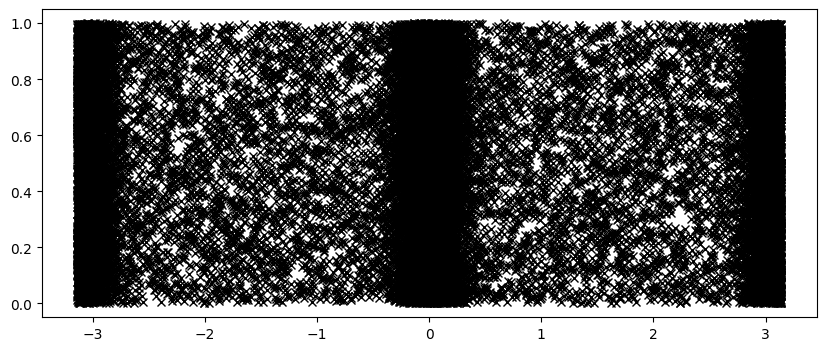

✅ Loaded trained_params from: /content/drive/MyDrive/StokesWave_lamd=1.0719_beta=0.0200_weights.pkl


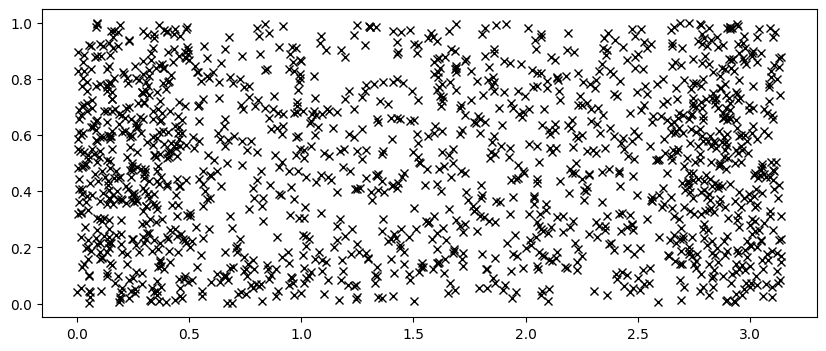

7.321697008742531e-07


In [14]:
# number of sampling points
N_smp = 2*15000
N_fix = [3*251, 3*201, 3*71]  # [col, deri, mid]
N_col = [3*121, 3*121]    # [col, deri]
#coeff = [0.1, 0., 0.1]  # [col, deri, mid]
coeff = [0.1, 0., 0.]  # [col, deri, mid] #changed July

# set the size of domain
lmt = jnp.array([pd, scl])

# initial guess of the lambda value
beta = 0.02 #0.01 #(1/2) * (1/3) #0.018 #0.001961  #surface tension
lamb0 = lamb1 #1.0794653821725166 #1.080461330209451 #1.078262455750391 #0.766370899997104 #0.766370999996873 #0.7664547515344482 #0.766370999996873 #0.766592951360124 #(1/2 + 1/3)**(1/2) #(1+beta)**(1/2) #1/2 + 2 * beta # #1.099 #((1+0.9*0.9)/(1-0.9*0.9))**(0.5)#0.6080921649065164# 1-scl**2/16 #Velocity, Remind that this is the sqrt of \mu=c^2/g  #1. + scl**2/2
g=1 #gravity

# surface tension
#beta = 0.0999998 #1/2#0.089616#0.001
n = 1
m = 2
epsilon = (scl)**6 #((1+jnp.sqrt(3)/(2*jnp.sqrt(2)))) #error for y''(0), need for surface tension

# vorticity
omega0 = 0#0.15#2.5

# set the training iteration
epoch2 = 8000 #15000  #was 40000
lw = 0.1
ew =  jnp.array([1.]) #jnp.array([1., 0.05])

# training freedom
eta0 = 0.001#0.00001
eta1 = 0.001#0.00001

# Symmetric condition setting
delta = 0 #0.01 #0.04  # degree of asymmetry
sym = False  # whether trigger the asymmetric condition

# prepare the normalization condition
x_nm = jnp.array([[0.]])
cond_nm = jnp.array([[y_0]])
# group all the conditions and collocation points
cond = dict(cond_nm=[x_nm, cond_nm])

# prepare the sampling point for HT
# x_smp0 = jnp.linspace(-1, 1, N_smp)
# x_smp = jnp.sign(x_smp0) * jnp.abs(x_smp0) ** 1.4 * jnp.pi
x_smp = data_eqfunc1D([-jnp.pi, jnp.pi], N_smp, lev=200, b=0.05)#lev was 100
# create the hilbert transform function based on the sampling
hptrans = hilb_perid_cubic(x_smp)

fig = plt.figure(figsize=(10, 4), dpi=100)
ax = plt.subplot(111)
ax.plot(x_smp, random.uniform(keys[0], x_smp.shape), 'kx', linewidth=1, label='col.point')
plt.show()

# prepare the collocation points to evaluate equation gradient
dataf, weighf, F0 = data_func_create(N_fix, N_col, coeff)
# sampling the data
data_z = dataf(keys[0], F0)
weigh = weighf(wp=0.1)
data = dwcombine(data_z, weigh)

# initialize the weights and biases of the network
##trained_params = stwv_init_MLP(keys[1], n_hl, n_unit)
trained_params = stwv_init_or_load(keys[1], n_hl, n_unit, weights_path=weights_path)  # added by Michal July

# read one group of collocation points
x_c = data['col'][0]
x_d = data['grad'][0]

plot = 1
if plot == 1:
    fig = plt.figure(figsize=(10, 4), dpi=100)
    ax = plt.subplot(111)
    ax.plot(x_c, random.uniform(keys[0], x_c.shape), 'kx', linewidth=1, label='col.point')
    plt.show()

# create the solution function
predf = stwv_pred_create(lmt)
# calculate the loss function
stwv_loss = loss_create(predf, cond, lamb0, lw, ew)
# update the loss reference based on the real loss
stwv_loss.ref = stwv_loss(trained_params, data)[0]
print(stwv_loss.ref)


In [15]:
"""Training using KFAC"""
# training the network using KFAC
trained_params, loss = kfac_optimizer(keys[2], stwv_loss, kfac_config, trained_params, dataf, F0, epoch2)

# generate the loss history
loss_all = np.array(loss)

# get the inferred lamb
lamb = lamb0 + eta1 * jnp.tanh(trained_params[-1])[0]
print(lamb)

Step: 50 | Loss: 5.7864e-07 | Loss_d: 3.6303e-11 | Loss_e: 5.7860e-06 | lamb: 1.072916 | Dp: 9.1385e-01
Step: 100 | Loss: 1.4413e-07 | Loss_d: 1.3114e-11 | Loss_e: 1.4412e-06 | lamb: 1.072916 | Dp: 8.2680e-01
Step: 150 | Loss: 5.6777e-08 | Loss_d: 1.4914e-11 | Loss_e: 5.6762e-07 | lamb: 1.072916 | Dp: 7.4805e-01
Step: 200 | Loss: 4.1466e-08 | Loss_d: 1.4372e-12 | Loss_e: 4.1465e-07 | lamb: 1.072916 | Dp: 6.7679e-01
Step: 250 | Loss: 3.4885e-08 | Loss_d: 6.1236e-14 | Loss_e: 3.4885e-07 | lamb: 1.072916 | Dp: 6.1233e-01
Step: 300 | Loss: 3.1379e-08 | Loss_d: 4.5636e-13 | Loss_e: 3.1379e-07 | lamb: 1.072916 | Dp: 5.5400e-01
Step: 350 | Loss: 2.9246e-08 | Loss_d: 2.3663e-13 | Loss_e: 2.9246e-07 | lamb: 1.072916 | Dp: 5.0123e-01
Step: 400 | Loss: 2.7724e-08 | Loss_d: 2.3790e-13 | Loss_e: 2.7723e-07 | lamb: 1.072916 | Dp: 4.5349e-01
Step: 450 | Loss: 2.6571e-08 | Loss_d: 1.6313e-13 | Loss_e: 2.6571e-07 | lamb: 1.072916 | Dp: 4.1029e-01
Step: 500 | Loss: 2.5672e-08 | Loss_d: 1.1118e-13 | Loss

1.0729156188654583


In [16]:
# calculate the equation residue
f_y = lambda x: predf(trained_params, x)
f_yx = lambda x: vectgrad(f_y, x)[0]

# calculate the solution
x_star = jnp.linspace(-2*jnp.pi, 2*jnp.pi, num=1001)[:, None]

y_x, y_p = vectgrad(f_y, x_star)
Hy_p = hptrans(x_star, f_y)
Hy_x = hptrans(x_star, f_yx)

# compute the equation residue
f = stwv_gov_eqn(f_y, x_star, lamb)
df = stwv_deri_eqn(f_y, x_star, lamb)

ExpName = f"StokesWave_lamd={lamb:.4f}_beta={beta:.4f}"

mdic = {"lamb": np.array(lamb), "eta": np.array(eta1), "x": np.array(x_star),
        "y": np.array(y_p), "Hy": np.array(Hy_p), "Hy_x": np.array(Hy_x),
        "y_x": np.array(y_x), "f": np.array(f), "df": df, "loss": loss_all}
FileName = ExpName + '.mat'


# save weights # added by Michal July
weights_path = str(rootdir.joinpath(ExpName + '_weights.pkl'))  # same naming
with open(weights_path, 'wb') as f:
    pickle.dump(trained_params, f)  # added by Michal July

# Saving the output

In [17]:
FilePath = str(rootdir.joinpath(FileName))
savemat(FilePath, mdic)
